In [5]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from transformers import AutoTokenizer
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.data_loader import create_dataloaders, load_dimabsa_dataset
from src.models.deberta_dimabsa import DeBERTaDimABSA, DeBERTaDimABSAConfig
from src.models.baselines import (
    BERTDimABSA,
    RoBERTaDimABSA,
    AspectMeanPoolingModel,
    TransformerVARegressor,
)
from src.trainer import (
    DimABSATrainer,
    TrainingConfig,
    train_model,
    evaluate_model,
)

class ProjectConfig:
    DATA_DIR = PROJECT_ROOT / "DimABSA2026" / "task-dataset" / "track_a" / "subtask_1"
    OUTPUT_DIR = PROJECT_ROOT / "outputs" / "experiments"
    MODEL_NAME = "microsoft/deberta-v3-base"
    MAX_LENGTH = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ProjectConfig.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Project root: {PROJECT_ROOT}")
print(f"Data dir: {ProjectConfig.DATA_DIR.resolve()}")
print(f"Device: {ProjectConfig.DEVICE}")

try:
    tokenizer = AutoTokenizer.from_pretrained(ProjectConfig.MODEL_NAME)
except Exception as e:
    print(f"Tokenizer load failed: {e}; retrying with use_fast=False")
    tokenizer = AutoTokenizer.from_pretrained(ProjectConfig.MODEL_NAME, use_fast=False)

raw_datasets = load_dimabsa_dataset(ProjectConfig.DATA_DIR, lang="eng", domain="laptop", split_dev=True)

print("Loaded dataset splits: ", {k: len(v) for k, v in raw_datasets.items()})


Project root: c:\Users\omerf\Desktop\Deep Learning\Project\DimABSA
Data dir: C:\Users\omerf\Desktop\Deep Learning\Project\DimABSA\DimABSA2026\task-dataset\track_a\subtask_1
Device: cpu


c:\Users\omerf\Desktop\Deep Learning\Project\DimABSA\.conda\Lib\site-packages\transformers\convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Loaded dataset splits:  {'train': 4462, 'dev': 496, 'test': 275}


In [6]:
# Prepare DataFrames from loaded raw_datasets
train_df = raw_datasets.get('train')
dev_df = raw_datasets.get('dev')
if train_df is None or dev_df is None:
    raise ValueError('train/dev splits not found in raw_datasets')

print(f"Train samples: {len(train_df)} | Dev samples: {len(dev_df)}")
display(train_df.head())


Train samples: 4462 | Dev samples: 496


,ID,Text,Aspect,Valence,Arousal
0,laptop_quad_dev_190,"if i had it to do over , i would not purchase ...",computer,3.10,6.30
1,laptop_quad_train_2141,after charging the unit for 2 hours i discover...,unit,4.75,5.25
2,laptop_quad_dev_253,"freezes with red lines across it , froze five ...",NULL,2.00,7.67
3,laptop_quad_train_1230,a wonderful device with extremely clear display .,device,8.00,7.83
4,laptop_quad_test_236,the screen does look good .,screen,6.62,6.62


In [7]:
# Create DataLoaders and inspect a batch
BATCH_SIZE = 16
train_loader, dev_loader = create_dataloaders(
    train_df=train_df,
    dev_df=dev_df,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    max_length=ProjectConfig.MAX_LENGTH,
    use_aspect_aware=True
)

print(f"Train batches: {len(train_loader)} | Dev batches: {len(dev_loader)}")
batch = next(iter(train_loader))
print('Batch keys and shapes:')
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(f"  {k}: {v.shape}")
    else:
        print(f"  {k}: {type(v).__name__}")


Train batches: 279 | Dev batches: 31
Batch keys and shapes:
  input_ids: torch.Size([16, 128])
  attention_mask: torch.Size([16, 128])
  token_type_ids: torch.Size([16, 128])
  aspect_mask: torch.Size([16, 128])
  labels: torch.Size([16, 2])
  text: list
  aspect: list


In [8]:
param_grid = {
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'batch_size': [8,16,32],
    'num_epochs': [3]
}

keys, values = zip(*param_grid.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Prepared {len(experiments)} experiments")
for i, exp in enumerate(experiments[:5], 1):
    print(f"{i}: {exp}")

def run_experiment(exp):
    # Build training config
    cfg = TrainingConfig(learning_rate=exp['learning_rate'], num_epochs=exp['num_epochs'])
    # DeBERTa + Attention + Lexicon model
    model_cfg = DeBERTaDimABSAConfig(model_name=ProjectConfig.MODEL_NAME, use_lexicon=True, lexicon_feature_dim=8)
    model = DeBERTaDimABSA(model_cfg)
    return model, cfg

# Create example model (no training) for the first experiment
example_model, example_cfg = run_experiment(experiments[0])
print(f"Example model params: {example_model.get_num_params():,}")

from src.lexicon import create_lexicon
try:
    lexicon = create_lexicon(PROJECT_ROOT / 'NRC-VAD-Lexicon-v2.1', use_dependency_parsing=False)
    lexicon_extractor = lambda texts, aspects: lexicon.extract_batch_features(texts, aspects)
    print('Lexicon loaded for experiment runs')
except Exception as e:
    print(f'Lexicon could not be loaded: {e}; proceeding without lexicon (zeros)')
    import torch
    def lexicon_extractor(texts, aspects):
        return torch.zeros((len(texts), 8), dtype=torch.float32)

USE_SUBSET = True
SUBSET_FRACTION = 0.1  
SUBSET_MAX = 1000      
if USE_SUBSET:
    take_n = min(len(train_df), max(1, int(len(train_df) * SUBSET_FRACTION)), SUBSET_MAX)
    train_df_subset = train_df.sample(n=take_n, random_state=42).reset_index(drop=True)
    print(f'Using subset of train: {len(train_df_subset)} samples (out of {len(train_df)})')
else:
    train_df_subset = train_df

hpo_results = []
total = len(experiments)
for idx, exp in enumerate(experiments, 1):
    print(f'== Experiment {idx}/{total}: {exp} ==')

    # Recreate dataloaders with requested batch size
    train_loader, dev_loader = create_dataloaders(
        train_df=train_df_subset,
        dev_df=dev_df,
        tokenizer=tokenizer,
        batch_size=exp['batch_size'],
        max_length=ProjectConfig.MAX_LENGTH,
        use_aspect_aware=True
    )

    # Build training config and model
    cfg = TrainingConfig(learning_rate=exp['learning_rate'], num_epochs=exp['num_epochs'], checkpoint_dir=str(ProjectConfig.OUTPUT_DIR / 'checkpoints'), device=str(ProjectConfig.DEVICE))
    model_cfg = DeBERTaDimABSAConfig(model_name=ProjectConfig.MODEL_NAME, use_lexicon=True, lexicon_feature_dim=8)
    model = DeBERTaDimABSA(model_cfg)

    # Run training (this may take time)
    results = train_model(model, train_loader, dev_loader, lexicon_extractor=lexicon_extractor, config=cfg, model_name=f"hpo_exp_{idx}")

    # Record results
    rec = {**exp, 'best_metric': results['best_metric'], 'best_epoch': results['best_epoch'], 'training_time': results['training_time']}
    hpo_results.append(rec)

    # Save intermediate results
    import pandas as _pd
    _pd.DataFrame(hpo_results).to_csv(ProjectConfig.OUTPUT_DIR / 'hpo_results_partial.csv', index=False)

print('All experiments completed. Results saved to', ProjectConfig.OUTPUT_DIR / 'hpo_results_partial.csv')

import pandas as pd
results_df = pd.DataFrame(hpo_results)
results_df.to_csv(ProjectConfig.OUTPUT_DIR / 'hpo_results_full.csv', index=False)
print('Saved final HPO results to', ProjectConfig.OUTPUT_DIR / 'hpo_results_full.csv')

print('Top 5 experiments:')
display(results_df.sort_values('best_metric').head(5))


Prepared 9 experiments
1: {'learning_rate': 2e-05, 'batch_size': 8, 'num_epochs': 3}
2: {'learning_rate': 2e-05, 'batch_size': 16, 'num_epochs': 3}
3: {'learning_rate': 2e-05, 'batch_size': 32, 'num_epochs': 3}
4: {'learning_rate': 3e-05, 'batch_size': 8, 'num_epochs': 3}
5: {'learning_rate': 3e-05, 'batch_size': 16, 'num_epochs': 3}
Example model params: 192,629,763
Loaded 54801 terms from NRC VAD Lexicon
Lexicon loaded for experiment runs
Using subset of train: 446 samples (out of 4462)
== Experiment 1/9: {'learning_rate': 2e-05, 'batch_size': 8, 'num_epochs': 3} ==

Starting training: hpo_exp_1
  Device: cpu
  Epochs: 3
  Learning rate: 2e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 56/56 [05:59<00:00,  6.42s/it, loss=1.8246, avg_loss=4.5726] 



Epoch 1 Results:
  Train Loss: 4.5726
  Val Loss: 2.3786
  Val RMSE_VA: 1.5423
  Val PCC_V: 0.7232
  Val PCC_A: 0.5061
  -> New best model saved! (rmse_va: 1.5423)


Epoch 2/3: 100%|██████████| 56/56 [05:54<00:00,  6.32s/it, loss=0.2888, avg_loss=2.1437]



Epoch 2 Results:
  Train Loss: 2.1437
  Val Loss: 2.0900
  Val RMSE_VA: 1.4457
  Val PCC_V: 0.7835
  Val PCC_A: 0.5550
  -> New best model saved! (rmse_va: 1.4457)


Epoch 3/3: 100%|██████████| 56/56 [05:07<00:00,  5.49s/it, loss=0.8758, avg_loss=1.5095]



Epoch 3 Results:
  Train Loss: 1.5095
  Val Loss: 1.9802
  Val RMSE_VA: 1.4072
  Val PCC_V: 0.8040
  Val PCC_A: 0.5558
  -> New best model saved! (rmse_va: 1.4072)

Training completed in 1298.7s
Best epoch: 3
Best rmse_va: 1.4072

== Experiment 2/9: {'learning_rate': 2e-05, 'batch_size': 16, 'num_epochs': 3} ==

Starting training: hpo_exp_2
  Device: cpu
  Epochs: 3
  Learning rate: 2e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 28/28 [04:45<00:00, 10.20s/it, loss=3.1641, avg_loss=4.7285]



Epoch 1 Results:
  Train Loss: 4.7285
  Val Loss: 2.8527
  Val RMSE_VA: 1.6890
  Val PCC_V: 0.7492
  Val PCC_A: 0.4751
  -> New best model saved! (rmse_va: 1.6890)


Epoch 2/3: 100%|██████████| 28/28 [04:36<00:00,  9.88s/it, loss=1.6501, avg_loss=2.1794]



Epoch 2 Results:
  Train Loss: 2.1794
  Val Loss: 2.0156
  Val RMSE_VA: 1.4197
  Val PCC_V: 0.8249
  Val PCC_A: 0.5349
  -> New best model saved! (rmse_va: 1.4197)


Epoch 3/3: 100%|██████████| 28/28 [04:34<00:00,  9.81s/it, loss=1.7213, avg_loss=1.5042]



Epoch 3 Results:
  Train Loss: 1.5042
  Val Loss: 1.8312
  Val RMSE_VA: 1.3532
  Val PCC_V: 0.8302
  Val PCC_A: 0.5608
  -> New best model saved! (rmse_va: 1.3532)

Training completed in 1110.2s
Best epoch: 3
Best rmse_va: 1.3532

== Experiment 3/9: {'learning_rate': 2e-05, 'batch_size': 32, 'num_epochs': 3} ==

Starting training: hpo_exp_3
  Device: cpu
  Epochs: 3
  Learning rate: 2e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 14/14 [05:44<00:00, 24.64s/it, loss=3.9312, avg_loss=4.7087]



Epoch 1 Results:
  Train Loss: 4.7087
  Val Loss: 3.6810
  Val RMSE_VA: 1.9220
  Val PCC_V: 0.5919
  Val PCC_A: 0.3732
  -> New best model saved! (rmse_va: 1.9220)


Epoch 2/3: 100%|██████████| 14/14 [04:38<00:00, 19.89s/it, loss=3.1070, avg_loss=3.5753]



Epoch 2 Results:
  Train Loss: 3.5753
  Val Loss: 2.9123
  Val RMSE_VA: 1.7147
  Val PCC_V: 0.7227
  Val PCC_A: 0.5025
  -> New best model saved! (rmse_va: 1.7147)


Epoch 3/3: 100%|██████████| 14/14 [04:02<00:00, 17.29s/it, loss=1.9571, avg_loss=2.6202]



Epoch 3 Results:
  Train Loss: 2.6202
  Val Loss: 2.3396
  Val RMSE_VA: 1.5394
  Val PCC_V: 0.7538
  Val PCC_A: 0.5413
  -> New best model saved! (rmse_va: 1.5394)

Training completed in 1117.3s
Best epoch: 3
Best rmse_va: 1.5394

== Experiment 4/9: {'learning_rate': 3e-05, 'batch_size': 8, 'num_epochs': 3} ==

Starting training: hpo_exp_4
  Device: cpu
  Epochs: 3
  Learning rate: 3e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 56/56 [05:19<00:00,  5.71s/it, loss=6.7315, avg_loss=3.9946]



Epoch 1 Results:
  Train Loss: 3.9946
  Val Loss: 4.4040
  Val RMSE_VA: 2.0986
  Val PCC_V: 0.6922
  Val PCC_A: 0.5701
  -> New best model saved! (rmse_va: 2.0986)


Epoch 2/3: 100%|██████████| 56/56 [05:12<00:00,  5.58s/it, loss=2.6062, avg_loss=2.0734]



Epoch 2 Results:
  Train Loss: 2.0734
  Val Loss: 1.8313
  Val RMSE_VA: 1.3533
  Val PCC_V: 0.8235
  Val PCC_A: 0.5741
  -> New best model saved! (rmse_va: 1.3533)


Epoch 3/3: 100%|██████████| 56/56 [06:16<00:00,  6.73s/it, loss=1.8733, avg_loss=1.2194]



Epoch 3 Results:
  Train Loss: 1.2194
  Val Loss: 1.7511
  Val RMSE_VA: 1.3233
  Val PCC_V: 0.8355
  Val PCC_A: 0.6038
  -> New best model saved! (rmse_va: 1.3233)

Training completed in 1277.4s
Best epoch: 3
Best rmse_va: 1.3233

== Experiment 5/9: {'learning_rate': 3e-05, 'batch_size': 16, 'num_epochs': 3} ==

Starting training: hpo_exp_5
  Device: cpu
  Epochs: 3
  Learning rate: 3e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 28/28 [05:40<00:00, 12.17s/it, loss=3.2985, avg_loss=3.8278]



Epoch 1 Results:
  Train Loss: 3.8278
  Val Loss: 2.0751
  Val RMSE_VA: 1.4405
  Val PCC_V: 0.7860
  Val PCC_A: 0.5465
  -> New best model saved! (rmse_va: 1.4405)


Epoch 2/3: 100%|██████████| 28/28 [05:13<00:00, 11.20s/it, loss=0.9622, avg_loss=1.7463]



Epoch 2 Results:
  Train Loss: 1.7463
  Val Loss: 1.9014
  Val RMSE_VA: 1.3789
  Val PCC_V: 0.8180
  Val PCC_A: 0.5578
  -> New best model saved! (rmse_va: 1.3789)


Epoch 3/3: 100%|██████████| 28/28 [05:16<00:00, 11.29s/it, loss=2.0932, avg_loss=1.2186]



Epoch 3 Results:
  Train Loss: 1.2186
  Val Loss: 1.8245
  Val RMSE_VA: 1.3508
  Val PCC_V: 0.8259
  Val PCC_A: 0.5812
  -> New best model saved! (rmse_va: 1.3508)

Training completed in 1285.3s
Best epoch: 3
Best rmse_va: 1.3508

== Experiment 6/9: {'learning_rate': 3e-05, 'batch_size': 32, 'num_epochs': 3} ==

Starting training: hpo_exp_6
  Device: cpu
  Epochs: 3
  Learning rate: 3e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 14/14 [11:05<00:00, 47.55s/it, loss=2.8338, avg_loss=4.3314]



Epoch 1 Results:
  Train Loss: 4.3314
  Val Loss: 3.0777
  Val RMSE_VA: 1.7614
  Val PCC_V: 0.6927
  Val PCC_A: 0.5139
  -> New best model saved! (rmse_va: 1.7614)


Epoch 2/3: 100%|██████████| 14/14 [04:54<00:00, 21.02s/it, loss=3.0422, avg_loss=2.4443]



Epoch 2 Results:
  Train Loss: 2.4443
  Val Loss: 2.2600
  Val RMSE_VA: 1.5144
  Val PCC_V: 0.7690
  Val PCC_A: 0.5484
  -> New best model saved! (rmse_va: 1.5144)


Epoch 3/3: 100%|██████████| 14/14 [04:36<00:00, 19.78s/it, loss=1.6251, avg_loss=1.6354]



Epoch 3 Results:
  Train Loss: 1.6354
  Val Loss: 2.1126
  Val RMSE_VA: 1.4639
  Val PCC_V: 0.7939
  Val PCC_A: 0.5727
  -> New best model saved! (rmse_va: 1.4639)

Training completed in 1517.3s
Best epoch: 3
Best rmse_va: 1.4639

== Experiment 7/9: {'learning_rate': 5e-05, 'batch_size': 8, 'num_epochs': 3} ==

Starting training: hpo_exp_7
  Device: cpu
  Epochs: 3
  Learning rate: 5e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 56/56 [06:03<00:00,  6.49s/it, loss=1.7690, avg_loss=3.1190] 



Epoch 1 Results:
  Train Loss: 3.1190
  Val Loss: 2.2693
  Val RMSE_VA: 1.5064
  Val PCC_V: 0.8127
  Val PCC_A: 0.5946
  -> New best model saved! (rmse_va: 1.5064)


Epoch 2/3: 100%|██████████| 56/56 [05:58<00:00,  6.40s/it, loss=1.3666, avg_loss=1.6506]



Epoch 2 Results:
  Train Loss: 1.6506
  Val Loss: 1.6010
  Val RMSE_VA: 1.2653
  Val PCC_V: 0.8502
  Val PCC_A: 0.6383
  -> New best model saved! (rmse_va: 1.2653)


Epoch 3/3: 100%|██████████| 56/56 [05:58<00:00,  6.40s/it, loss=0.5828, avg_loss=1.0261]



Epoch 3 Results:
  Train Loss: 1.0261
  Val Loss: 1.6841
  Val RMSE_VA: 1.2977
  Val PCC_V: 0.8455
  Val PCC_A: 0.6447
  -> No improvement (1/3)

Training completed in 1365.4s
Best epoch: 2
Best rmse_va: 1.2653

== Experiment 8/9: {'learning_rate': 5e-05, 'batch_size': 16, 'num_epochs': 3} ==

Starting training: hpo_exp_8
  Device: cpu
  Epochs: 3
  Learning rate: 5e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 28/28 [05:08<00:00, 11.02s/it, loss=3.1208, avg_loss=5.4509] 



Epoch 1 Results:
  Train Loss: 5.4509
  Val Loss: 3.2942
  Val RMSE_VA: 1.8150
  Val PCC_V: 0.7095
  Val PCC_A: 0.4256
  -> New best model saved! (rmse_va: 1.8150)


Epoch 2/3: 100%|██████████| 28/28 [05:16<00:00, 11.31s/it, loss=1.5485, avg_loss=2.3615]



Epoch 2 Results:
  Train Loss: 2.3615
  Val Loss: 2.0297
  Val RMSE_VA: 1.4247
  Val PCC_V: 0.7966
  Val PCC_A: 0.5137
  -> New best model saved! (rmse_va: 1.4247)


Epoch 3/3: 100%|██████████| 28/28 [05:37<00:00, 12.06s/it, loss=1.0977, avg_loss=1.6761]



Epoch 3 Results:
  Train Loss: 1.6761
  Val Loss: 1.8131
  Val RMSE_VA: 1.3465
  Val PCC_V: 0.8266
  Val PCC_A: 0.5810
  -> New best model saved! (rmse_va: 1.3465)

Training completed in 1330.5s
Best epoch: 3
Best rmse_va: 1.3465

== Experiment 9/9: {'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 3} ==

Starting training: hpo_exp_9
  Device: cpu
  Epochs: 3
  Learning rate: 5e-05
  Training samples: 446
  Validation samples: 496



Epoch 1/3: 100%|██████████| 14/14 [05:46<00:00, 24.77s/it, loss=2.2805, avg_loss=4.4842]



Epoch 1 Results:
  Train Loss: 4.4842
  Val Loss: 2.0816
  Val RMSE_VA: 1.4558
  Val PCC_V: 0.7816
  Val PCC_A: 0.5834
  -> New best model saved! (rmse_va: 1.4558)


Epoch 2/3: 100%|██████████| 14/14 [04:26<00:00, 19.05s/it, loss=1.8717, avg_loss=2.0640]



Epoch 2 Results:
  Train Loss: 2.0640
  Val Loss: 1.8771
  Val RMSE_VA: 1.3752
  Val PCC_V: 0.8225
  Val PCC_A: 0.6055
  -> New best model saved! (rmse_va: 1.3752)


Epoch 3/3: 100%|██████████| 14/14 [04:35<00:00, 19.64s/it, loss=0.9166, avg_loss=1.3885]



Epoch 3 Results:
  Train Loss: 1.3885
  Val Loss: 1.7474
  Val RMSE_VA: 1.3273
  Val PCC_V: 0.8396
  Val PCC_A: 0.6085
  -> New best model saved! (rmse_va: 1.3273)

Training completed in 1193.9s
Best epoch: 3
Best rmse_va: 1.3273

All experiments completed. Results saved to c:\Users\omerf\Desktop\Deep Learning\Project\DimABSA\outputs\experiments\hpo_results_partial.csv
Saved final HPO results to c:\Users\omerf\Desktop\Deep Learning\Project\DimABSA\outputs\experiments\hpo_results_full.csv
Top 5 experiments:


,learning_rate,batch_size,num_epochs,best_metric,best_epoch,training_time
6,0.00005,8,3,1.265300,2,1365.354890
3,0.00003,8,3,1.323293,3,1277.414842
8,0.00005,32,3,1.327279,3,1193.921880
7,0.00005,16,3,1.346506,3,1330.511967
4,0.00003,16,3,1.350751,3,1285.262816


In [18]:
import matplotlib as mpl
import seaborn as sns

sns.set_theme(
    style="white",
    context="talk",
    font_scale=1.05
)

mpl.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.1,
    "grid.color": "#E6E6E6",
    "grid.linestyle": "--",
    "grid.linewidth": 0.6
})

<Figure size 800x500 with 0 Axes>

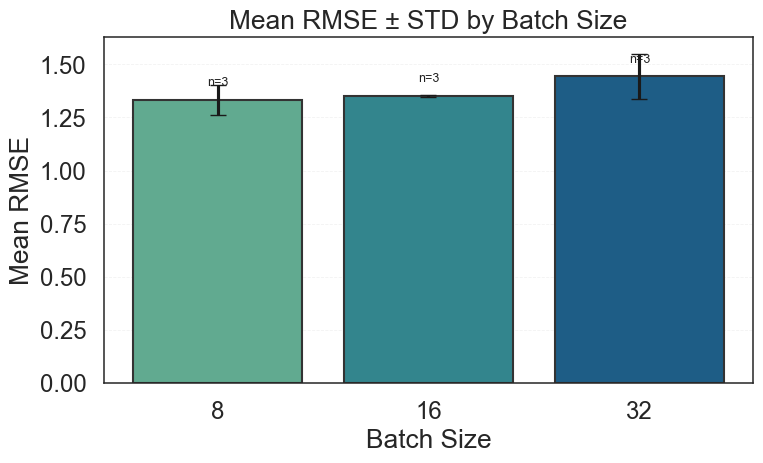

In [36]:
# Bar plot: Mean ± STD RMSE per Batch Size with counts annotated
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

OUT_DIR = ProjectConfig.OUTPUT_DIR
OUT_DIR.mkdir(parents=True, exist_ok=True)
results_file = OUT_DIR / 'hpo_results_full.csv'
if not results_file.exists():
    print('No HPO results file found at', results_file)
else:
    df = pd.read_csv(results_file)
    df = df.dropna(subset=['batch_size', 'best_metric'])
    df['batch_size'] = df['batch_size'].astype(int)

    grp = df.groupby('batch_size')['best_metric'].agg(['mean', 'std', 'count']).reset_index().sort_values('batch_size')

    plt.figure(figsize=(8,5))
    sns.set_style('white')
    colors = sns.color_palette('crest', n_colors=len(grp))

    fig, ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(grp['batch_size'].astype(str), grp['mean'], yerr=grp['std'], capsize=6, color=colors, edgecolor='#333333')

    ax.set_xlabel('Batch Size')
    ax.set_ylabel('Mean RMSE')
    ax.set_title('Mean RMSE ± STD by Batch Size')

    # Annotate counts above bars
    for bar, cnt in zip(bars, grp['count']):
        ax.annotate(f'n={int(cnt)}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 8), textcoords='offset points', ha='center', va='bottom', fontsize=9, color='#222222')

    ax.grid(axis='y', linestyle='--', alpha=0.25)
    plt.tight_layout()
    fig.savefig(OUT_DIR / 'hpo_bar_mean_std_bs.png', dpi=200)
    plt.show()

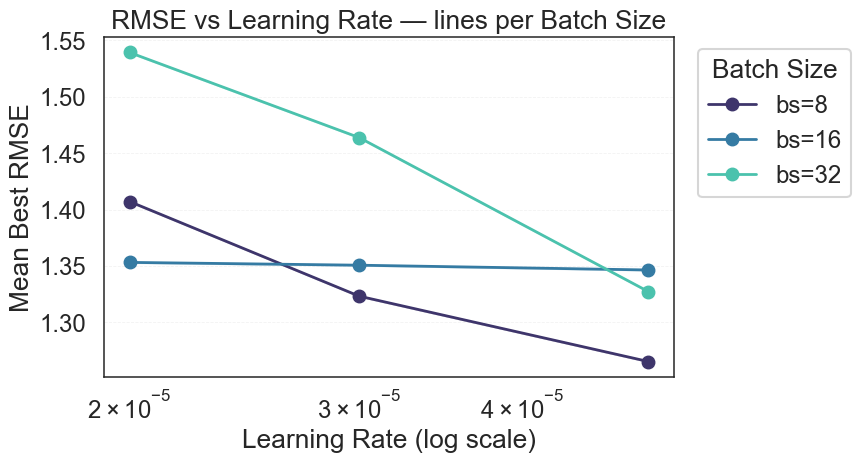

In [ ]:
# Line plot: RMSE vs Learning Rate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

OUT_DIR = ProjectConfig.OUTPUT_DIR
results_file = OUT_DIR / 'hpo_results_full.csv'
if not results_file.exists():
    print('No HPO results file found at', results_file)
else:
    df = pd.read_csv(results_file)
    df = df.dropna(subset=['learning_rate','best_metric'])
    df['learning_rate'] = pd.to_numeric(df['learning_rate'], errors='coerce')
    if 'batch_size' in df.columns:
        df['batch_size'] = df['batch_size'].astype(int)

    # Aggregate mean and sem for error ribbon
    agg = df.groupby(['learning_rate','batch_size'])['best_metric'].agg(['mean','sem']).reset_index()
    plt.figure(figsize=(9,5))
    palette = sns.color_palette('mako', n_colors=len(agg['batch_size'].unique()))
    for i, (bs, grp) in enumerate(agg.groupby('batch_size')):
        x = grp['learning_rate']
        y = grp['mean']
        yerr = grp['sem'].fillna(0)
        plt.plot(x, y, marker='o', label=f'bs={bs}', color=palette[i], linewidth=2)
        plt.fill_between(x, y - yerr, y + yerr, color=palette[i], alpha=0.15)

    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Mean Best RMSE')
    plt.title('RMSE vs Learning Rate — lines per Batch Size')
    plt.legend(title='Batch Size', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.25)
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'hpo_line_lr_by_bs.png', dpi=200, bbox_inches='tight')
    plt.show()

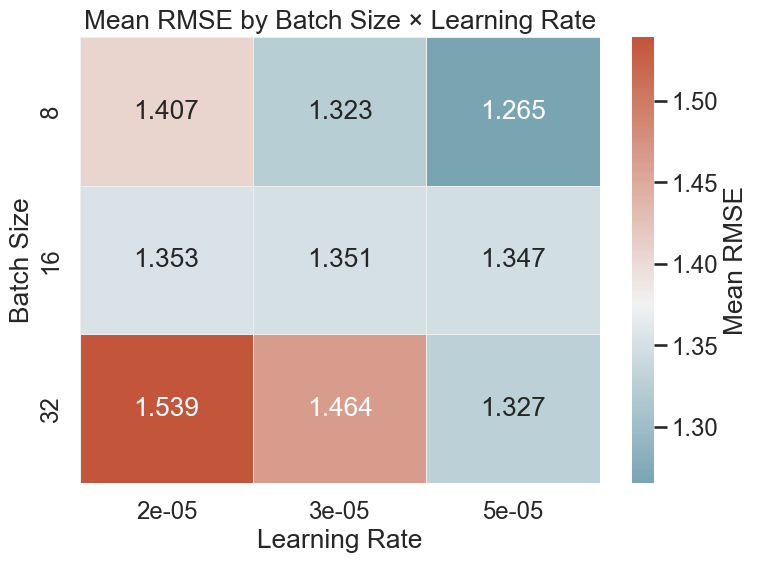

In [38]:
# Heatmap: Batch Size × Learning Rate (mean RMSE)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

OUT_DIR = ProjectConfig.OUTPUT_DIR
results_file = OUT_DIR / 'hpo_results_full.csv'
if not results_file.exists():
    print('No HPO results file found at', results_file)
else:
    df = pd.read_csv(results_file)
    df = df.dropna(subset=['batch_size','learning_rate','best_metric'])
    df['batch_size'] = df['batch_size'].astype(int)
    df['learning_rate'] = pd.to_numeric(df['learning_rate'], errors='coerce')

    pivot = df.groupby(['batch_size','learning_rate'])['best_metric'].mean().unstack()
    plt.figure(figsize=(8,6))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap=cmap, center=np.nanmean(df['best_metric']), linewidths=0.5, linecolor='#EEEEEE', cbar_kws={'label':'Mean RMSE'})
    plt.title('Mean RMSE by Batch Size × Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Batch Size')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'hpo_heatmap_bs_lr.png', dpi=200)
    plt.show()

C:\Users\omerf\AppData\Local\Temp\ipykernel_5920\2825753855.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=topk, x='best_metric', y='config', palette=palette)


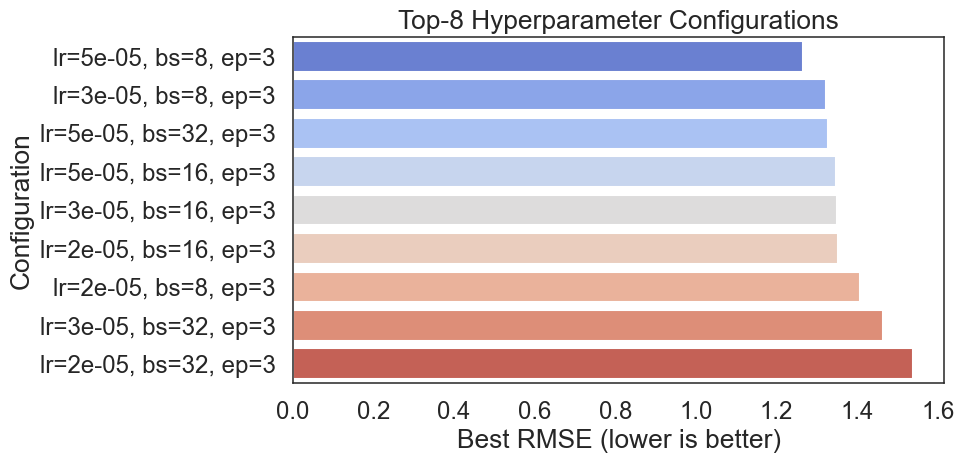

In [42]:
# Top-8 horizontal bar: best configs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

OUT_DIR = ProjectConfig.OUTPUT_DIR
results_file = OUT_DIR / 'hpo_results_full.csv'
if not results_file.exists():
    print('No HPO results file found at', results_file)
else:
    df = pd.read_csv(results_file)
    topk = df.nsmallest(10, 'best_metric').copy()
    topk['config'] = topk.apply(lambda r: f"lr={r.learning_rate}, bs={int(r.batch_size)}, ep={int(r.num_epochs)}", axis=1)
    plt.figure(figsize=(10,5))
    palette = sns.color_palette('coolwarm', n_colors=len(topk))
    ax = sns.barplot(data=topk, x='best_metric', y='config', palette=palette)
    plt.xlabel('Best RMSE (lower is better)')
    plt.ylabel('Configuration')
    plt.title('Top-8 Hyperparameter Configurations')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'hpo_top8_configs.png', dpi=200)
    plt.show()

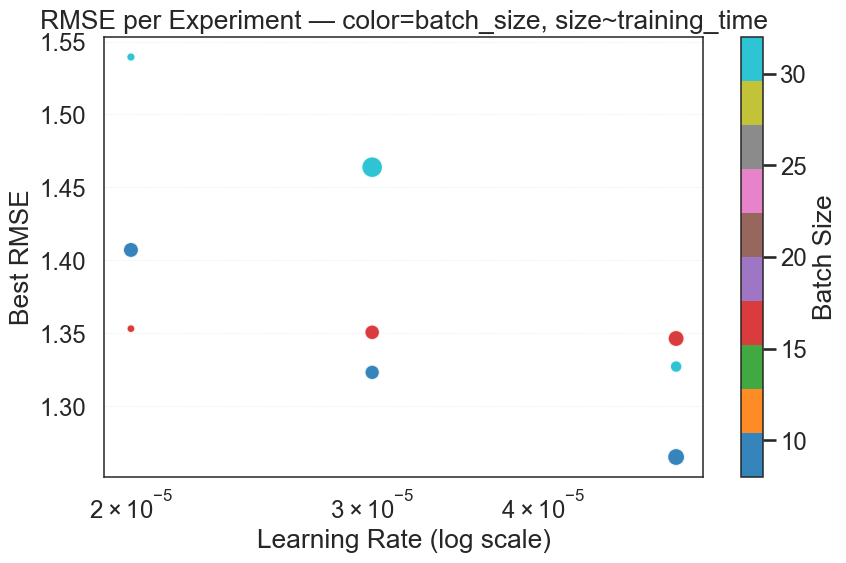

In [40]:
# Scatter: Learning Rate vs Best RMSE — color by batch size, size by training time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

OUT_DIR = ProjectConfig.OUTPUT_DIR
results_file = OUT_DIR / 'hpo_results_full.csv'
if not results_file.exists():
    print('No HPO results file found at', results_file)
else:
    df = pd.read_csv(results_file)
    df = df.dropna(subset=['learning_rate','best_metric'])
    df['learning_rate'] = pd.to_numeric(df['learning_rate'], errors='coerce')
    if 'batch_size' in df.columns:
        df['batch_size'] = df['batch_size'].astype(int)

    sizes = None
    if 'training_time' in df.columns:
        tt = pd.to_numeric(df['training_time'], errors='coerce').fillna(0)
        sizes = ( (tt - tt.min()) / (tt.max()-tt.min() + 1e-6) ) * 200 + 40
    else:
        sizes = np.full(len(df), 80)

    plt.figure(figsize=(9,6))
    sc = plt.scatter(df['learning_rate'], df['best_metric'], c=df.get('batch_size', 0), s=sizes, cmap='tab10', alpha=0.9, edgecolor='w')
    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Best RMSE')
    plt.title('RMSE per Experiment — color=batch_size, size~training_time')
    cbar = plt.colorbar(sc)
    cbar.set_label('Batch Size')
    plt.grid(axis='y', linestyle='--', alpha=0.25)
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'hpo_scatter_lr_rmse_separate.png', dpi=200)
    plt.show()